# `kohgpjax` example with 2 calibration parameters

In [8]:
import os

from models import toy2d1d as KOHmodel
from data.toy2d1d.dataloader import DataLoader
from kohgpjax.mappings import mapRto01, map01toR, mapRto0inf, map0inftoR
from jax import jit, grad

import numpy as np
import matplotlib.pyplot as plt

import mici
import arviz

from truefuncs import zeta
eta = zeta

plot_style = {
    'mathtext.fontset': 'cm',
    'font.family': 'serif',
    'axes.titlesize': 10,
    'axes.labelsize': 10,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 8,
    'legend.frameon': False,
    'axes.linewidth': 0.5,
    'lines.linewidth': 0.5,
    'axes.labelpad': 2.,
    'figure.dpi': 150,
}

## The Data

In [9]:
dataloader = DataLoader(
    os.getcwd() + '/data/toy2d1d/',
    os.getcwd() + '/data/toy2d1d/',
)
data = dataloader.get_data()
model = KOHmodel.Model(*data)

tmax = dataloader.t_max
tmin = dataloader.t_min

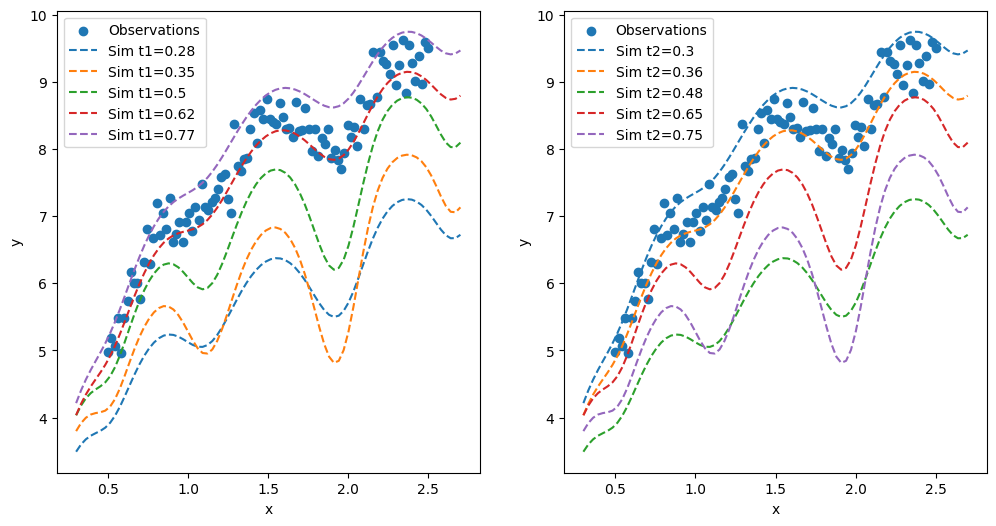

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  

ax = axes[0]
ax.scatter(dataloader.xf, dataloader.yf, label='Observations')
# def disc(x):
#     return 0.14*np.sin(x*np.pi)
# ax.plot(dataloader.xf, zeta(dataloader.xf, 0.4)+disc(dataloader.xf), label='True function')
for t in np.unique(dataloader.tc[:,0]):
    rows = dataloader.tc[:,0]==t
    ax.plot(dataloader.xc[rows], dataloader.yc[rows], '--', label=f'Sim t1={t}')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()

ax = axes[1]
ax.scatter(dataloader.xf, dataloader.yf, label='Observations')
for t in np.unique(dataloader.tc[:,1]):
    rows = dataloader.tc[:,1]==t
    ax.plot(dataloader.xc[rows], dataloader.yc[rows], '--', label=f'Sim t2={t}')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()

plt.show()

## MCMC Setup

In [11]:
theta_0 = 0.5
theta_1 = 0.5

ell_eta_0_0 = 1 # np.sqrt(np.var(dataloader.xf))/3
ell_eta_1_0 = 0.3 # np.sqrt(np.var(dataloader.tc))/3
ell_eta_2_0 = 0.3 # np.sqrt(np.var(dataloader.tc))/3
ell_delta_0_0 = 1 # np.sqrt(np.var(dataloader.xf))/5

lambda_eta_0 = 0.5
lambda_delta_0 = 10000 # currently no discrepancy so make this very small
lambda_epsilon_0 = 10
lambda_epsilon_eta_0 = 10000

init_states = np.array([[
    map01toR(theta_0), 
    map01toR(theta_1),
    map0inftoR(ell_eta_0_0),
    map0inftoR(ell_eta_1_0),
    map0inftoR(ell_eta_2_0),
    map0inftoR(ell_delta_0_0),
    map0inftoR(lambda_eta_0),
    map0inftoR(lambda_delta_0),
    map0inftoR(lambda_epsilon_0),
    map0inftoR(lambda_epsilon_eta_0),
]])

In [12]:
param_transform_mici_to_gpjax = lambda x: [
    [ # theta (calibration) parameters
        mapRto01(x[0]),
        mapRto01(x[1]),
    ],
    [ # lengthscale parameters
        mapRto0inf(x[2]), 
        mapRto0inf(x[3]), 
        mapRto0inf(x[4]),
        mapRto0inf(x[5]),
    ],
    [ # lambda (variance) parameters
        mapRto0inf(x[6]), 
        mapRto0inf(x[7]), 
        mapRto0inf(x[8]), 
        mapRto0inf(x[9]),
    ]
]

Build the function for evaluating the negative log posterior density.

This function is jitted and grad jitted using JAX. Finally the JAX functions are wrapped into a numpy function for clean interactions with Mici.

In [13]:
jitted_neg_log_posterior_density = jit(
    model.get_KOH_neg_log_pos_dens_func(
        param_transform_mici_to_gpjax
    )
)
grad_neg_log_posterior_density = jit(grad(
    model.get_KOH_neg_log_pos_dens_func(
        param_transform_mici_to_gpjax
    )
))

def neg_log_pos_dens(x):
    return np.asarray(jitted_neg_log_posterior_density(x))

def grad_neg_log_pos_dens(x):
    return np.asarray(grad_neg_log_posterior_density(x))

##### Mici #####
system = mici.systems.EuclideanMetricSystem(
    neg_log_dens=neg_log_pos_dens,
    grad_neg_log_dens=grad_neg_log_pos_dens,
)
integrator = mici.integrators.LeapfrogIntegrator(system)

## Running MCMC algorithm

In [14]:
seed = 1234
n_chain = 1
n_warm_up_iter = 800
n_main_iter = 500
rng = np.random.default_rng(seed)

##### Mici sampler and adapters #####
sampler = mici.samplers.StaticMetropolisHMC(system, integrator, rng, n_step=3)
# sampler = mici.samplers.DynamicMultinomialHMC(system, integrator, rng) # "STAN algorithm"
adapters = [
    mici.adapters.DualAveragingStepSizeAdapter(0.8),
    mici.adapters.OnlineCovarianceMetricAdapter()
]

def trace_func(state):
    return {
        'm_theta_0': state.pos[0], 
        'm_theta_1': state.pos[1],
        'm_ell_eta_0': state.pos[2], 
        'm_ell_eta_1': state.pos[3],
        'm_ell_eta_2': state.pos[4],
        'm_ell_delta_0': state.pos[5],
        'm_lambda_eta': state.pos[6],
        'm_lambda_delta': state.pos[7],
        'm_lambda_epsilon': state.pos[8],
        'm_lambda_epsilon_eta': state.pos[9],
        'hamiltonian': system.h(state)
    }

final_states, traces, stats = sampler.sample_chains(
    n_warm_up_iter, 
    n_main_iter, 
    init_states, 
    adapters=adapters, 
    n_process=n_chain, # only 1 works on MacOS
    trace_funcs=[trace_func]
)

/Users/jamesbriant/miniforge3/envs/py311/lib/python3.11/site-packages/cola/backends/backends.py:75: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)
/Users/jamesbriant/miniforge3/envs/py311/lib/python3.11/site-packages/cola/backends/backends.py:75: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


Sampling stage: Initial fast adaptive [00:09] > Slow adaptive (1/4) [00:03] > Slow adaptive (2/4) [00:05] > Slow adaptive (3/4) [00:10] > Slow adaptive (4/4) [00:51] > Final fast adaptive [00:05] > Main non-adaptive [00:52]

Chain 1/1: 100%|██████████|500/500 [00:52<00:00, 9.51it/s, accept_stat=0.935]

## Analyse MCMC output

In [15]:
arviz.summary(traces)

Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
hamiltonian,-1482.655,3.289,-1488.067,-1476.588,0.292,0.207,117.0,299.0,NaN
m_ell_delta_0,-0.450,0.581,-1.559,0.486,0.148,0.106,17.0,87.0,NaN
m_ell_eta_0,-1.684,0.022,-1.726,-1.645,0.001,0.001,244.0,251.0,NaN
m_ell_eta_1,0.721,0.123,0.505,0.955,0.008,0.005,264.0,401.0,NaN
m_ell_eta_2,0.738,0.179,0.407,1.049,0.007,0.006,562.0,107.0,NaN
m_lambda_delta,9.124,0.340,8.558,9.777,0.099,0.072,13.0,140.0,NaN
m_lambda_epsilon,2.978,0.137,2.731,3.227,0.008,0.006,281.0,400.0,NaN
m_lambda_epsilon_eta,11.808,0.085,11.661,11.978,0.005,0.004,244.0,396.0,NaN
m_lambda_eta,-1.407,0.295,-1.957,-0.896,0.017,0.012,305.0,474.0,NaN
m_theta_0,-1.275,0.085,-1.431,-1.115,0.005,0.004,370.0,94.0,NaN


In [16]:
for var, trace in traces.items():
    print(var, ": ", np.mean(trace[0]), '±', np.std(trace[0]))

m_theta_0 :  -1.2749627067592502 ± 0.08484992609608179
m_theta_1 :  1.5749511652809844 ± 0.4440887497246722
m_ell_eta_0 :  -1.6844521706032243 ± 0.022280099268560682
m_ell_eta_1 :  0.7205988606467285 ± 0.12257773934719204
m_ell_eta_2 :  0.7378744211606684 ± 0.1784607314818551
m_ell_delta_0 :  -0.4496431028786343 ± 0.5807041652462422
m_lambda_eta :  -1.4068807951450222 ± 0.2947555676692679
m_lambda_delta :  9.123809067141524 ± 0.3393205735364998
m_lambda_epsilon :  2.977630057795514 ± 0.1365696625279317
m_lambda_epsilon_eta :  11.807783032104242 ± 0.0844203104276071
hamiltonian :  -1482.6547281970327 ± 3.285517840672131


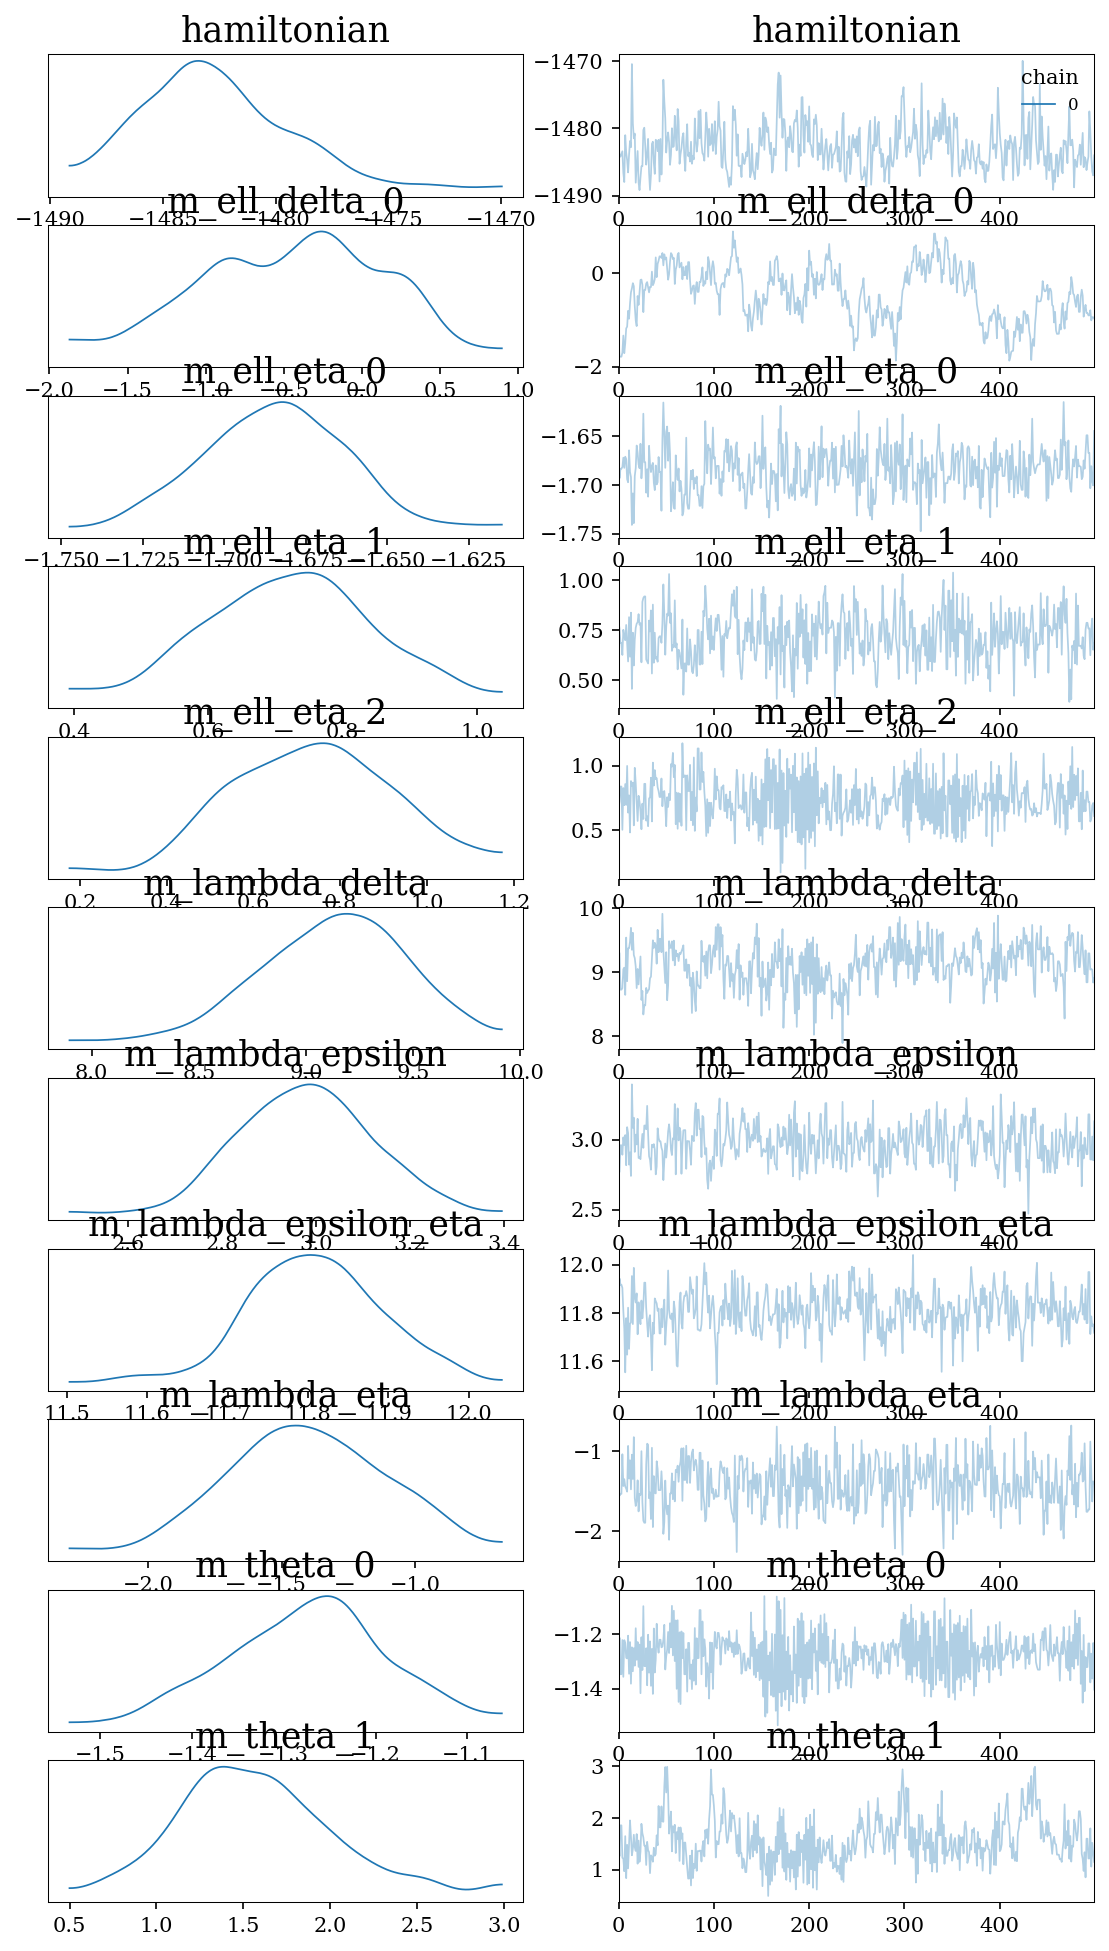

In [17]:
with plt.style.context(plot_style):
    arviz.plot_trace(
        traces,
        # var_names=["σ", "ϵ", "γ", "β", "x_0"],
        figsize=(9, 2 * (8)),
        legend=True,
        compact=False,
    )


## Transform the chains

In [24]:
traces_transformed = {}
for var, trace in traces.items():
    if var == 'hamiltonian':
        continue
    var_name = var.split('m_')[1]
    if var_name.startswith('theta'):
        calib_var_num = int(var_name.split('_')[1])
        traces_transformed[var_name] = mapRto01(trace[0])*(tmax[calib_var_num]-tmin[calib_var_num]) + tmin[calib_var_num]
    elif var_name.startswith('ell'):
        traces_transformed[var_name] = mapRto0inf(trace[0])
    elif var_name.startswith('lambda'):
        traces_transformed[var_name] = mapRto0inf(trace[0])
    elif var_name == 'period':
        traces_transformed[var_name] = mapRto0inf(trace[0])

params_transformed = {}
for var, trace in traces_transformed.items():
    params_transformed[var] = np.mean(trace)
    print(var, ": ", np.mean(trace), '±', np.std(trace))

theta_0 :  0.6628103312555338 ± 0.007080820372104458
theta_1 :  0.38111831701222343 ± 0.027302836924681502
ell_eta_0 :  0.1855921404873398 ± 0.004139628007719665
ell_eta_1 :  2.071128618389807 ± 0.2537501833396877
ell_eta_2 :  2.1250616532764885 ± 0.38148941865938124
ell_delta_0 :  0.7486966229020343 ± 0.422209064525778
lambda_eta :  0.2556972795870274 ± 0.07579569323571679
lambda_delta :  9691.697448133655 ± 3166.5361774493126
lambda_epsilon :  19.825338187988667 ± 2.7215988148578054
lambda_epsilon_eta :  134770.38820866562 ± 11312.213008044615


In [25]:
arviz.summary(traces_transformed)

Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ell_delta_0,0.749,0.423,0.154,1.488,0.099,0.071,17.0,87.0,NaN
ell_eta_0,0.186,0.004,0.178,0.193,0.000,0.000,244.0,251.0,NaN
ell_eta_1,2.071,0.254,1.658,2.599,0.016,0.011,264.0,401.0,NaN
ell_eta_2,2.125,0.382,1.458,2.800,0.017,0.013,562.0,107.0,NaN
lambda_delta,9691.697,3169.707,3403.176,15206.355,782.788,563.671,13.0,140.0,NaN
lambda_epsilon,19.825,2.724,15.350,25.204,0.161,0.114,281.0,400.0,NaN
lambda_epsilon_eta,134770.388,11323.542,115812.647,159000.585,722.114,511.218,244.0,396.0,NaN
lambda_eta,0.256,0.076,0.140,0.407,0.004,0.003,305.0,474.0,NaN
theta_0,0.663,0.007,0.649,0.675,0.000,0.000,370.0,94.0,NaN
theta_1,0.381,0.027,0.331,0.434,0.006,0.005,20.0,54.0,NaN


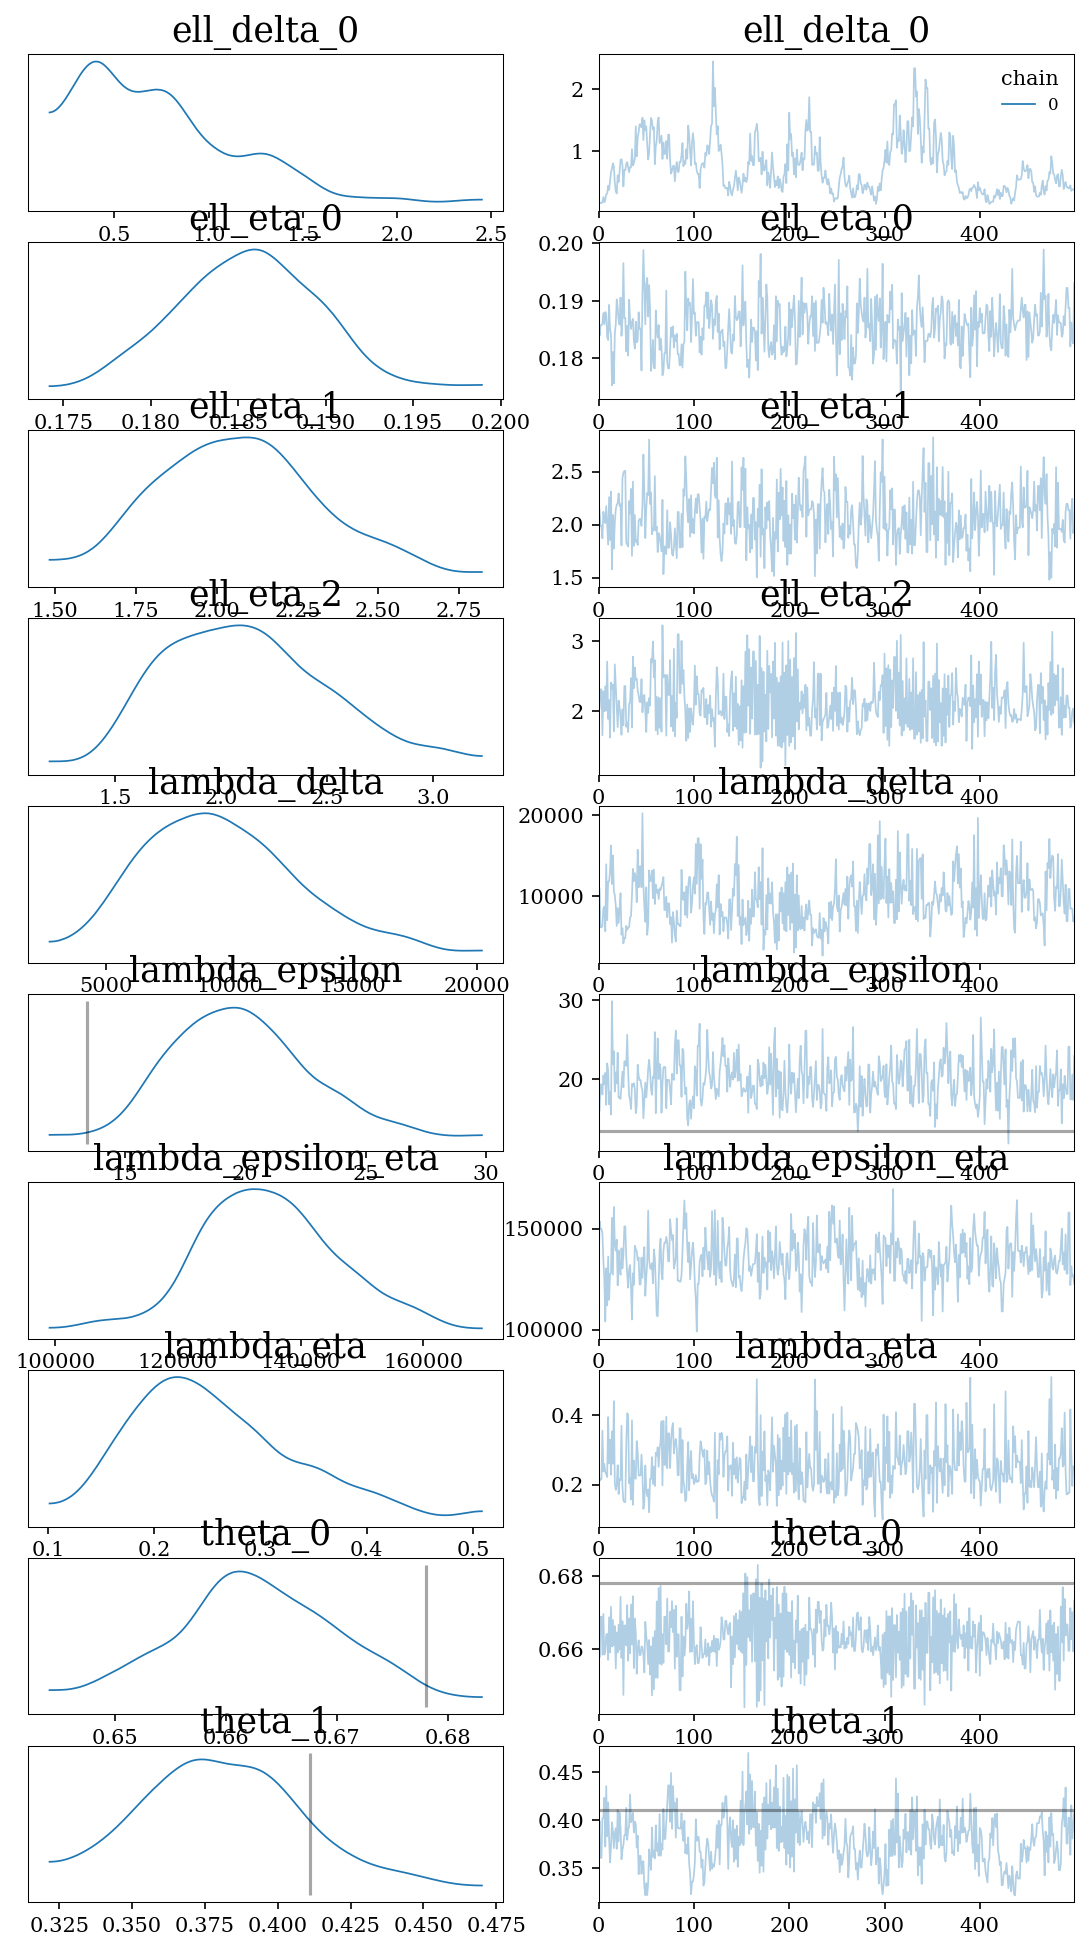

In [26]:
with plt.style.context(plot_style):
    arviz.plot_trace(
        traces_transformed,
        figsize=(9, 2 * (8)),
        legend=True,
        compact=False,
        lines=(
            ('theta_0', {}, 0.678),
            ('theta_1', {}, 0.411),
            ('lambda_epsilon', {}, 1/0.273**2)    
        )
    )
plt.show()